In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sb
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Model

In [2]:
class Model:
    #################################################
    # List of basic parameters
    #################################################

    # Share of Keynesian agents
    lamb = 0.21
    
    # Discount rate
    beta = 0.99
    
    # Curvature of consumption
    sigma = 1
    
    # Inverse frisch elasticity
    varphi = 3
    
    # Openness of the economy
    upsilon = 0.4
    
    # Elasticity of substitution between goods in country
    varepsilon = 6
    
    # Elasticity of substitution between countries
    gamma = 1
    
    # Elasticity of substitution between home and foreign consumption
    eta = 1
        
    # Share of firms not adjusting prices
    theta = 0.75
    
    # Tax rate, also includes function to set it to optimal (for simulations)
    tau = 1 - (6-1)/(6*(1-0.4))
    def set_optimal_tau(self):
        self.tau = 1 - 1/(self.M*(1-self.upsilon))
    
    # Response of interest rate to inflation
    phi_pi = 1.5
    
    # Autocorrelation of technology
    rho_a = 0.66
    
    # Autocorrelation of interest rate shock
    rho_v = 0.5
    
    # Initial value of the interest rate shock - corresponds to 1% increase in yearly inflation
    initial_v_shock = 0.25
    
    # Initial value of the technology shock
    initial_a_shock = 1
    
    #################################################
    # List of compounded parameters
    #################################################
   
    @property
    def rho(self):
        return 1/self.beta - 1
    
    # Tax rate stuff
    @property
    def nu(self):
        return -math.log(1-self.tau)
    
    # Margin
    @property
    def M(self):
        return self.varepsilon/(self.varepsilon-1)
    
    @property
    def mu(self):
        return math.log(self.M)
    
    @property
    def omega(self):
        return self.sigma*self.gamma + (1-self.upsilon)*(self.sigma*self.eta-1)
    
    @property
    def sigma_upsilon(self):
        return self.sigma/(1-self.upsilon + self.upsilon*self.omega)
    
    @property
    def delta(self):
        return (1-self.upsilon)*(self.sigma/self.sigma_upsilon - self.upsilon*(self.omega-1))
        
    #Simplifies stuff a bit
    @property
    def gamma_lower(self):
        return self.M*(1-self.tau) + self.sigma/self.varphi
    
    @property
    def gamma_c(self):
        return self.sigma*(1+1/self.varphi)/self.gamma_lower
    
    @property
    def gamma_n(self):
        return (1+self.varphi)/self.gamma_lower
    
    @property
    def chi_upsilon(self):
        return self.sigma_upsilon*(1-self.upsilon)/self.sigma

    @property
    def chi_lambda(self):
        return self.lamb/(1-self.lamb-self.lamb*(1-self.gamma_c)*(self.chi_upsilon*(1-self.upsilon)-1))
    
    # Effect of y on h
    @property
    def Theta_y(self):
        return self.chi_lambda*((1-self.gamma_c)*self.chi_upsilon - self.gamma_n)
    
    # Effect of y* on h
    @property
    def Theta_star(self):
        return self.chi_lambda*(1-self.gamma_c)*(1-self.chi_upsilon)
    
    # Effect of a on h
    @property
    def Theta_a(self):
        return -self.chi_lambda*self.gamma_n
    
    @property
    def zeta(self):
        return (1-self.beta*self.theta)*(1-self.theta)/self.theta
    
    @property
    def chi_h(self):
        return self.sigma - self.sigma_upsilon*(1-self.upsilon)
        
    @property
    def steady_state_y(self):
        return (self.nu-self.mu)/(self.sigma+self.varphi)
    
    #Helper
    @property
    def Gamma_lower(self):
        return self.varphi + self.sigma_upsilon - self.chi_h*self.Theta_y
     
    @property
    def Gamma(self):
        return (self.nu-self.mu-self.chi_h*(self.Theta_y+self.Theta_star)*self.steady_state_y)/self.Gamma_lower
    
    # Effect of a on natural y
    @property
    def Gamma_a(self):
        return (1 + self.varphi + self.chi_h*self.Theta_a)/self.Gamma_lower
    
    # Effect of y* on natural y
    @property
    def Gamma_star(self):
        return -(self.sigma-self.sigma_upsilon-self.chi_h*self.Theta_star)/self.Gamma_lower
    
    @property
    def kappa_h(self):
        return self.Gamma_lower*self.zeta
    
    @property
    def sigma_h(self):
        return self.sigma_upsilon*(1 + self.delta*self.Theta_y)

    #################################################
    # Equilibrium values of variables
    #################################################
    
    # Computes the nominal interest rate, given values of v and domestic inflation
    def i(self, pi_H, v):
        return self.rho + self.phi_pi*pi_H + v
    
    # Computes the natural level of output, given a and y*
    def y_bar(self, a, y_star):
        return self.Gamma + self.Gamma_a*a + self.Gamma_star*y_star
 
    # Computes y, given output gap and natural output
    def y(self, natural_output, output_gap):
        return natural_output + output_gap
    
    # Computes the heterogeneity index, given output deviations from steady state (home and foreign) and a
    def h(self, y, y_star, a):
        return self.Theta_y*(y-self.steady_state_y) + self.Theta_star*(y_star-self.steady_state_y) + self.Theta_a*a 

    # Computes employment, given output and technology
    def n(self, y, a):
        return y - a
    
    # Computes the terms of trade, given foreign and domestic output and the heterogeneity index
    def s(self, y, y_star, h):
        return self.sigma_upsilon*(y-y_star+(1-self.upsilon)*h)
    
    # Computes consumption, given output, terms of trade and the heterogeneity index
    def c(self, y, h, s):
        return y - self.upsilon*(h + s*self.omega/self.sigma)

    # Computes the real wage given c and n
    def real_wage(self, c, n):
        return self.sigma*c + self.varphi*n

    # Computes CPI inflation, given domestic inflation and the change in terms of trade
    def pi(self, pi_H, s, s_prev):
        return pi_H + self.upsilon*(s-s_prev)    

    # Computes the real rate, given the values of the nominal interest rate and (expected) inflation in the next period
    def r(self, i, pi_next):
        return i - pi_next
        
    #################################################
    # Impulse responses
    #################################################

    # Used for impulse responses - depends on the autocorrelation of the impulse
    def Lambda_h(self, rho_par):
        return 1/((1-self.beta*rho_par)*(self.sigma_h*(1-rho_par)) + self.kappa_h*(self.phi_pi-rho_par))

    # This gets impulse responses for all variables, once we have values of a, v, y_star, x and pi_H
    def full_response(self, impulse_responses):
        
        # Get the nominal interest rate, natural output, output, heterogeneity index, labor, 
        # terms of trade, consumption and the real wage
        impulse_responses['i'] = impulse_responses.apply(lambda x: self.i(x['pi_H'], x['v']), axis=1)
        impulse_responses['y_bar'] = impulse_responses.apply(lambda x: self.y_bar(x['a'], x['y_star']), axis=1)
        impulse_responses['y'] = impulse_responses.apply(lambda x: self.y(x['y_bar'], x['x']), axis=1)
        impulse_responses['h'] = impulse_responses.apply(lambda x: self.h(x['y'], x['y_star'], x['a']), axis=1)
        impulse_responses['n'] = impulse_responses.apply(lambda x: self.n(x['y'], x['a']), axis=1)
        impulse_responses['s'] = impulse_responses.apply(lambda x: self.s(x['y'], x['y_star'], x['h']), axis=1)
        impulse_responses['c'] = impulse_responses.apply(lambda x: self.c(x['y'], x['h'], x['s']), axis=1)
        impulse_responses['real_wage'] = impulse_responses.apply(lambda x: self.real_wage(x['c'], x['n']), axis=1)

        # Get the impulse response for CPI inflation and real interest rate
        # Temp column for the previous value of s
        impulse_responses['s_prev'] = [0] + list(impulse_responses['s'][:-1])
        impulse_responses['pi'] = impulse_responses.apply(lambda x: self.pi(x['pi_H'], x['s'], x['s_prev']), axis=1)
        
        #Temp column for value of pi in the next period (set to 0 in last period, but that doesn't matter)
        impulse_responses['pi_next'] = list(impulse_responses['pi'][1:]) + [0]
        impulse_responses['r'] = impulse_responses.apply(lambda x: self.r(x['i'], x['pi_next']), axis=1)

        # Drop temp columns
        #impulse_responses.drop(columns=['s_prev', 'pi_next'], inplace=True)
        
        return impulse_responses
        
    #################################################
    # Response to interest rate shock

    def ouptut_gap_v(self, v):
        # Cofficient in y = effect * v
        effect = -(1-self.beta*self.rho_v)*self.Lambda_h(self.rho_v)           
        return v * effect

    def inflation_v(self, v):
        # Cofficient in pi = effect * v
        effect = -self.kappa_h*self.Lambda_h(self.rho_v)           
        return v * effect
    
    def impulse_responses_v(self, periods = 100, set_tau=False):
        periods = range(periods)  
        
        if set_tau:
            self.set_optimal_tau()
            
        # Set up base values
        a_values = [0 for t in periods]
        v_values = [self.initial_v_shock*(self.rho_v**t) for t in periods]
        y_star_values = [self.steady_state_y for t in periods]
        
        impulse_responses = pd.DataFrame({'a': a_values, 'v': v_values, 'y_star':y_star_values})
        
        # Get the output gap and domestic inflation
        impulse_responses['x'] = impulse_responses.apply(lambda x: self.ouptut_gap_v(x['v']), axis=1)
        impulse_responses['pi_H'] = impulse_responses.apply(lambda x: self.inflation_v(x['v']), axis=1)
        
        # Get the response of everything else
        impulse_responses = self.full_response(impulse_responses)
        
        return impulse_responses
    
    #################################################
    # Response to technology shock
    def ouptut_gap_a(self, a):
        # Cofficient in y = effect * a
        effect = (self.rho_a-1)*(self.sigma_upsilon*self.delta*self.Theta_a + self.sigma_h*self.Gamma_a)*(1-self.beta*self.rho_a)*self.Lambda_h(self.rho_a)    
        return effect * a

    def inflation_a(self, a):
        # Cofficient in pi = effect * a
        effect = (self.rho_a-1)*(self.sigma_upsilon*self.delta*self.Theta_a + self.sigma_h*self.Gamma_a)*self.kappa_h*self.Lambda_h(self.rho_a)           
        return effect * a
    
    def impulse_responses_a(self, periods = 100, set_tau=False):
        periods = range(periods)  

        if set_tau:
            self.set_optimal_tau()

        # Set up base values
        a_values = [self.initial_a_shock*(self.rho_a**t) for t in periods]
        v_values = [0 for t in periods]
        y_star_values = [self.steady_state_y for t in periods]
        
        impulse_responses = pd.DataFrame({'a': a_values, 'v': v_values, 'y_star':y_star_values})
        
        # Get the output gap and domestic inflation
        impulse_responses['x'] = impulse_responses.apply(lambda x: self.ouptut_gap_a(x['a']), axis=1)
        impulse_responses['pi_H'] = impulse_responses.apply(lambda x: self.inflation_a(x['a']), axis=1)
        
        # Get the response of everything else
        impulse_responses = self.full_response(impulse_responses)
        
        return impulse_responses


# IADL

In [3]:
# IADL - closed
values = np.arange(0.0, 0.801, 0.01)
values_varphi = np.arange(0.0, 10, 0.1)

# The resulting array. Index holds varphi values, and columns hold lambda values
Sigma_closed = pd.DataFrame(index=values_varphi, columns=values)

test_model = Model()
test_model.upsilon = 0

for i in np.arange(0.0, 10, 0.1):
    for j in values:
        test_model.varphi = i
        test_model.lamb = j
        
        test_model.set_optimal_tau()
        Sigma_closed.loc[i,j] = test_model.sigma_h

/home/tadej/anaconda3/envs/quant/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in double_scalars
/home/tadej/anaconda3/envs/quant/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in double_scalars
/home/tadej/anaconda3/envs/quant/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


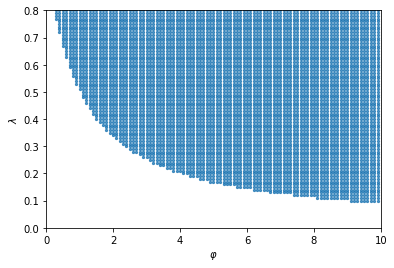

In [4]:
data_l = Sigma_closed.reset_index().melt(id_vars=['index']).rename(columns={'index':'X', 'variable': 'Y'})
ds = data_l.loc[data_l['value'] < 0]

k = sb.regplot(x=ds["X"], y=ds["Y"], fit_reg=False, scatter_kws={'s':5})
k.set(xlabel=r'$\varphi$', ylabel=r'$\lambda$')

k.axes.set_xlim(0,10)
k.axes.set_ylim(0,0.8)

plt.savefig('IADL.pdf', format='pdf')

In [5]:
# IADL - open
values = np.arange(0.0, 0.801, 0.01)

# The resulting array. Index holds upsilon values, and columns hold lambda values
Sigma_open = pd.DataFrame(index=values, columns=values)

test_model = Model()

for i in values:
    for j in values:
        test_model.upsilon = i
        test_model.lamb = j
        
        test_model.set_optimal_tau()
        Sigma_open.loc[i,j] = test_model.sigma_h

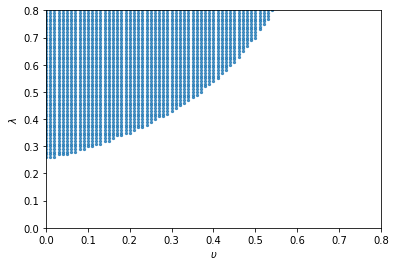

In [6]:
data_l = Sigma_open.reset_index().melt(id_vars=['index']).rename(columns={'index':'X', 'variable': 'Y'})
ds = data_l.loc[data_l['value'] < 0]

k = sb.regplot(x=ds["X"], y=ds["Y"], fit_reg=False, scatter_kws={'s':5})
k.set(xlabel=r'$\upsilon$', ylabel=r'$\lambda$')

k.axes.set_xlim(0,0.8)
k.axes.set_ylim(0,0.8)

plt.savefig('IADL_open.pdf', format='pdf')

# Impulse responses

In [7]:
# Full model, economy open and Keynesian agents present
full_calibration = Model()
full_calibration.set_optimal_tau()

# Closed economy with Keynesian agents
closed_heterogenous = Model()
closed_heterogenous.upsilon = 0
closed_heterogenous.set_optimal_tau()

# Open economy without Keynesian agents
open_representative = Model()
open_representative.lamb = 0
open_representative.set_optimal_tau()

# Closed economy without Keynesian agents
classic = Model()
classic.lamb = 0
classic.upsilon = 0
classic.set_optimal_tau()

In [8]:
# Names to show on the plot for variables
human_names = {
    'x': 'Output Gap',
    'y': 'Output',
    'pi_H': 'Domestic Inflation',
    'pi': 'CPI Inflation',
    'i': 'Nominal Interest Rate',
    'r': 'Real Interest Rate',
    's': 'Terms of Trade',
    'c': 'Consumption',
    'real_wage': 'Real wage',
    'n': 'Employment'
}

# Helper function (more of a hack than a solution) to get all reponse in a long table
def get_all_responses(imp_full, imp_closed, imp_open, imp_classic):
    imp_full['t'] = imp_full.index + 1
    imp_closed['t'] = imp_closed.index + 1
    imp_open['t'] = imp_open.index + 1
    imp_classic['t'] = imp_classic.index + 1

    # Remove any kind of retarded terms of trade and diff btw domestic and cpi inflation from closed models
    imp_closed.drop(columns=['s'], inplace=True)
    imp_classic.drop(columns=['s'], inplace=True)

    imp_closed['pi'] = imp_closed['pi_H']
    imp_classic['pi'] = imp_classic['pi_H']

    imp_full_melt = imp_full.melt(id_vars=['t'])
    imp_closed_melt = imp_closed.melt(id_vars=['t'])
    imp_open_melt = imp_open.melt(id_vars=['t'])
    imp_classic_melt = imp_classic.melt(id_vars=['t'])

    imp_full_melt['type'] = 'λ = 0.21, υ = 0.4'
    imp_closed_melt['type'] = 'λ = 0.21, υ = 0'
    imp_open_melt['type'] = 'λ = 0, υ = 0.4'
    imp_classic_melt['type'] = 'λ = 0, υ = 0'

    all_responses = pd.concat([imp_full_melt, imp_closed_melt, imp_open_melt, imp_classic_melt])
    all_responses['variable'] = all_responses['variable'].replace(human_names)
    return all_responses

In [9]:
periods = 10

# Response to shock in a
imp_full_a = full_calibration.impulse_responses_a(periods = periods)
imp_closed_a = closed_heterogenous.impulse_responses_a(periods = periods)
imp_open_a = open_representative.impulse_responses_a(periods = periods)
imp_classic_a = classic.impulse_responses_a(periods = periods)

all_responses_a = get_all_responses(imp_full_a, imp_closed_a, imp_open_a, imp_classic_a)

# Response to shock in b
imp_full_v = full_calibration.impulse_responses_v(periods = periods)
imp_closed_v = closed_heterogenous.impulse_responses_v(periods = periods)
imp_open_v = open_representative.impulse_responses_v(periods = periods)
imp_classic_v = classic.impulse_responses_v(periods = periods)

all_responses_v = get_all_responses(imp_full_v, imp_closed_v, imp_open_v, imp_classic_v)

In [10]:
# Order in which to show variables in case of a shock
order_a = ['Output Gap', 'Domestic Inflation', 'CPI Inflation',
           'Output', 'Employment', 'Real wage',
           'Real Interest Rate', 'h', 'a']

order_v = ['Output Gap', 'Domestic Inflation', 'CPI Inflation',
           'Output', 'Employment', 'Real wage',
           'Real Interest Rate', 'h', 'v']

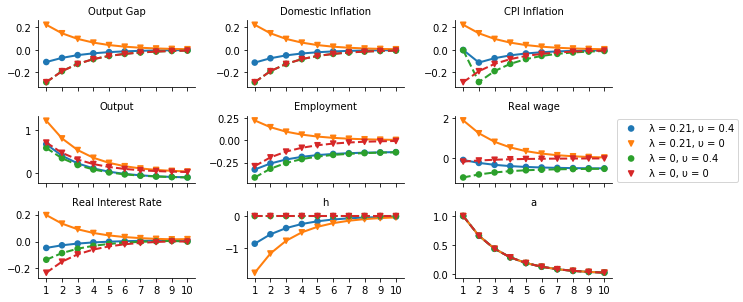

In [11]:
# Responses to shock in a
all_responses_a = all_responses_a[all_responses_a['variable'].isin(order_a)]

plot = sb.factorplot(x='t', y='value', hue='type', col='variable', col_order=order_a, 
                     col_wrap = 3, sharey=False, size=1.5, aspect=2, scale=0.75,
                     linestyles=['-', '-', '--', '--'], markers = ['o', 'v', 'o', 'v'], 
                     data = all_responses_a)
plot.set_titles(row_template = '{row_name}', col_template = '{col_name}')
plot.set_axis_labels('', '')

plot._legend.set_title('')
plt.savefig('impulse_a.pdf', format="pdf")

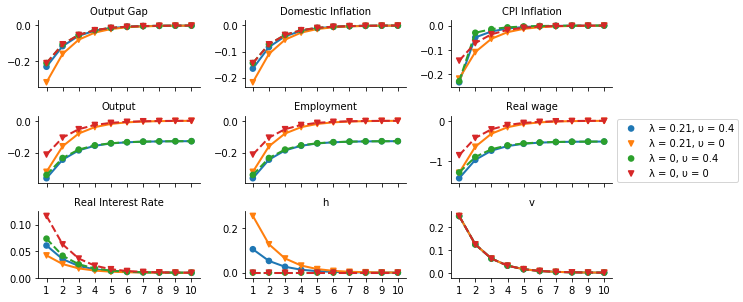

In [12]:
# Responses to shock in v
all_responses_v = all_responses_v[all_responses_v['variable'].isin(order_v)]

plot = sb.factorplot(x='t', y='value', hue='type', col='variable', col_order=order_v, 
                     col_wrap = 3, sharey=False, size=1.5, aspect=2, scale=0.75,
                     linestyles=['-', '-', '--', '--'], markers = ['o', 'v', 'o', 'v'], 
                     data = all_responses_v)
plot.set_titles(row_template = '{row_name}', col_template = '{col_name}')
plot.set_axis_labels('', '')

plot._legend.set_title('')
plt.savefig('impulse_v.pdf', format="pdf")

# Cumulative output gap response

In [13]:
# Cumulative effects analysis
values = np.arange(0.0, 0.8, 0.03)

# The resulting array. Index holds upsilon values, and columns hold lambda values
cumulative_gap_a = pd.DataFrame(index=values, columns=values)
cumulative_inflation_a = pd.DataFrame(index=values, columns=values)
cumulative_gap_v = pd.DataFrame(index=values, columns=values)
cumulative_inflation_v = pd.DataFrame(index=values, columns=values)

test_model = Model()
for i in values:
    for j in values:
        test_model.upsilon = i
        test_model.lamb = j
        test_model.set_optimal_tau()
        
        resp_a = test_model.impulse_responses_a(periods=10)
        cumulative_gap_a.loc[i,j] = resp_a['x'].sum()
        cumulative_inflation_a.loc[i,j] = resp_a['pi_H'].sum()
        
        resp_v = test_model.impulse_responses_v(periods=10)
        cumulative_gap_v.loc[i,j] = resp_v['x'].sum()
        cumulative_inflation_v.loc[i,j] = resp_v['pi_H'].sum()

In [14]:
# Transform the data
data_x_a = cumulative_gap_a.reset_index().melt(id_vars=['index']).rename(columns={'index':'X', 'variable': 'Y'})
data_pi_a = cumulative_inflation_a.reset_index().melt(id_vars=['index']).rename(columns={'index':'X', 'variable': 'Y'})

data_x_v = cumulative_gap_v.reset_index().melt(id_vars=['index']).rename(columns={'index':'X', 'variable': 'Y'})
data_pi_v = cumulative_inflation_v.reset_index().melt(id_vars=['index']).rename(columns={'index':'X', 'variable': 'Y'})

In [15]:
def plot_3d(data, file_name, limit = 5):
    # Draw the 3d plot
    # Cut the annoying data
    data['value'] = [max(-limit, min(x, limit)) for x in data['value']]

    # Make the plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf=ax.plot_trisurf(list(data['X']), list(data['Y']), list(data['value']),
                         vmin = -limit, vmax=limit, cmap=plt.cm.viridis, shade=False)
    fig.colorbar( surf, shrink=0.5, aspect=5)
    ax.set_xlabel('υ')
    ax.set_ylabel('λ')
    ax.set_zlim(-limit, limit)
 
    # Rotate it
    ax.view_init(45, 225)
    plt.tight_layout()
    plt.savefig(file_name, format="pdf")

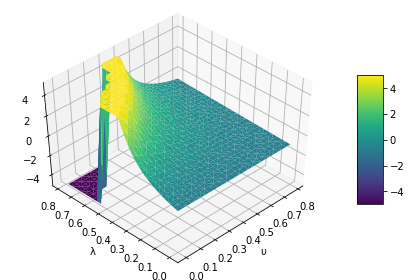

In [16]:
plot_3d(data_x_a, 'cumulative_x_a.pdf')

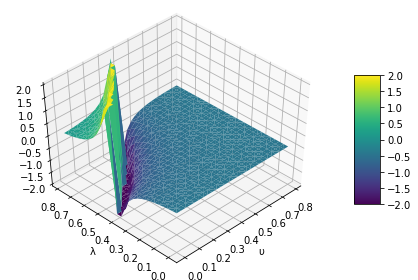

In [17]:
plot_3d(data_x_v, 'cumulative_x_v.pdf', limit=2)